In [2]:
import os
import torch
import re
import string
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as T
from torch.nn.utils.rnn import pad_sequence
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path =  "/kaggle/input/flickr8k"

In [5]:
captions = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
captions.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [6]:
captions.shape

(40455, 2)

In [7]:
tokenizer = Tokenizer()
text = "This is a good place to find a city"
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])
print(sequences[0])
print(tokenizer.index_word)
print(tokenizer.word_index)
print(tokenizer.word_counts)

[2, 3, 1, 4, 5, 6, 7, 1, 8]
{1: 'a', 2: 'this', 3: 'is', 4: 'good', 5: 'place', 6: 'to', 7: 'find', 8: 'city'}
{'a': 1, 'this': 2, 'is': 3, 'good': 4, 'place': 5, 'to': 6, 'find': 7, 'city': 8}
OrderedDict([('this', 1), ('is', 1), ('a', 2), ('good', 1), ('place', 1), ('to', 1), ('find', 1), ('city', 1)])


In [8]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.idx_to_word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.word_to_idx = {v: k for k, v in self.idx_to_word.items()}
        self.tokenizer = Tokenizer(oov_token="<UNK>")


    def __len__(self):
        return len(self.idx_to_word)

    def build_vocab(self, sentence_list):
        self.tokenizer.fit_on_texts(sentence_list)
        word_counts = Counter(self.tokenizer.word_counts)

        idx = len(self.idx_to_word)
        for word, count in word_counts.items():
            if count >= self.freq_threshold:
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word
                idx += 1

    def numericalize(self, text):
        tokens = self.tokenizer.texts_to_sequences([text])[0]
        return [self.word_to_idx.get(self.tokenizer.index_word[token], self.word_to_idx["<UNK>"]) for token in tokens]

In [9]:
vocab = Vocabulary(freq_threshold=1)
vocab.build_vocab(["This is a good place to find a city"])
print(vocab.word_to_idx)
print(vocab.idx_to_word)
print(vocab.numericalize("This is a good place to find a city here mere"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'this', 5: 'is', 6: 'a', 7: 'good', 8: 'place', 9: 'to', 10: 'find', 11: 'city'}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3]


In [10]:
def clean_caption(caption):
    caption = caption.lower()
    caption = caption = re.sub(r"[^A-Za-z]+"," ",caption) # remove all special character and digit
    caption = caption = re.sub(r"\s+"," ",caption) # convert multiple white spaces to one white space
    caption = ' '.join(caption.split())
    return caption

In [11]:
cap = "This is a good #place 2    two     to find a city here!!"
print(cap)
cap = clean_caption(cap)
print(cap)

This is a good #place 2    two     to find a city here!!
this is a good place two to find a city here


In [12]:
class FlickerDataset(Dataset):
    def __init__(self, images_path, captions_file, transform=None, freq_threshold=1,clean_caption=clean_caption):
        self.images_path = images_path
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.images = self.df["image"]
        self.captions = self.df["caption"].apply(clean_caption)
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        image_name = self.images[idx]
        image_location = os.path.join(self.images_path,image_name)
        img = Image.open(image_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.word_to_idx["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.word_to_idx["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [13]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [14]:
def show_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [16]:
dataset =  FlickerDataset(
    images_path = "/kaggle/input/flickr8k/Images",
    captions_file = "/kaggle/input/flickr8k/captions.txt",
    transform=transforms
)

print(len(dataset))

40455


In [49]:
len(dataset.vocab)

8445

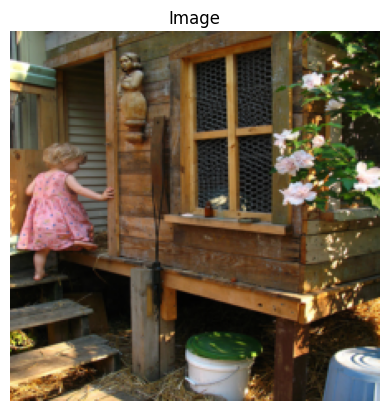

Token: tensor([ 1,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15, 16, 17,
         2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<EOS>']


In [17]:
img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.idx_to_word[token] for token in caps.tolist()])

In [18]:
vocab_size = len(dataset.vocab)
vocab_size

8445

In [19]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [20]:
BATCH_SIZE = 4
NUM_WORKER = 1
pad_idx = dataset.vocab.word_to_idx["<PAD>"]


# Split the dataset
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.05, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
print(len(train_dataset),len(test_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKER,shuffle=True,collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=False,collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

38432 2023


In [21]:
dataiter = iter(train_loader)
batch = next(dataiter)
images, captions = batch

print(images.shape)
print(captions.shape)
print(captions[0].shape)
print(captions[1].shape)
print(captions[2].shape)
print(captions[3].shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 18])
torch.Size([18])
torch.Size([18])
torch.Size([18])
torch.Size([18])


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


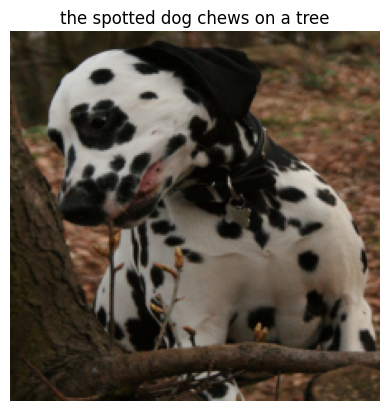

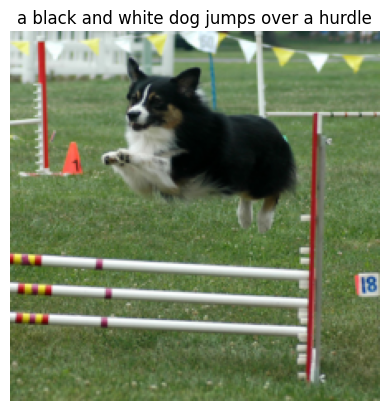

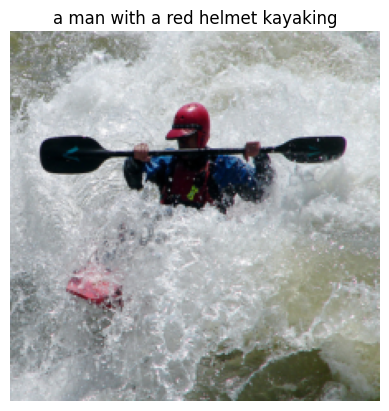

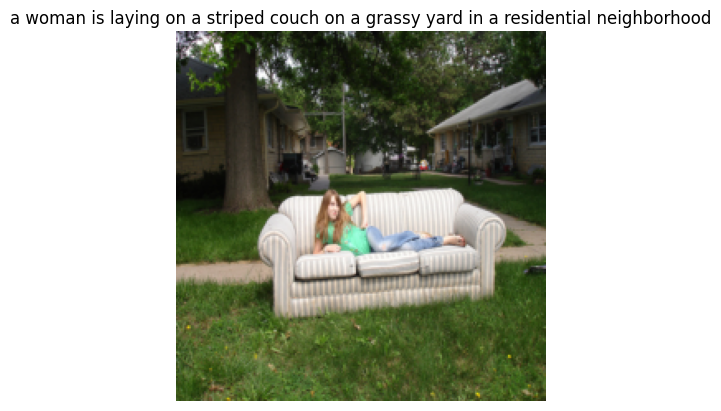

In [22]:
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.idx_to_word[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

In [23]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        return features

In [24]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        self.A = nn.Linear(attention_dim,1)

    def forward(self, features, hidden_state):
        u_hs = self.U(features)
        w_ah = self.W(hidden_state)
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        attention_scores = self.A(combined_states)
        attention_scores = attention_scores.squeeze(2)
        alpha = F.softmax(attention_scores,dim=1)
        attention_weights = features * alpha.unsqueeze(2)
        attention_weights = attention_weights.sum(dim=1)
        return alpha,attention_weights

In [25]:
#Attention Decoder
class DecoderLSTM(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)


    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            preds[:,s] = output
            alphas[:,s] = alpha

        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        alphas = []

        word = torch.tensor(vocab.word_to_idx['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())

            if vocab.idx_to_word[predicted_word_idx.item()] == "<EOS>":
                break

            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.idx_to_word[idx] for idx in captions],alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [26]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderLSTM(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [27]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [28]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s] 


In [29]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/kaggle/working/attention_model_state.pth')

In [30]:
num_epochs = 20
print_every = 1000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        optimizer.zero_grad()

        outputs,attentions = model(image, captions)

        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()

        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


    save_model(model,epoch)

Epoch: 1 loss: 3.92564
Epoch: 1 loss: 4.27866
Epoch: 1 loss: 3.30838
Epoch: 1 loss: 3.95016
Epoch: 1 loss: 4.36195
Epoch: 1 loss: 3.36142
Epoch: 1 loss: 3.27973
Epoch: 1 loss: 2.95785
Epoch: 1 loss: 3.36115
Epoch: 2 loss: 3.06625
Epoch: 2 loss: 2.97756
Epoch: 2 loss: 2.85976
Epoch: 2 loss: 2.68084
Epoch: 2 loss: 3.85594
Epoch: 2 loss: 3.60830
Epoch: 2 loss: 3.39218
Epoch: 2 loss: 2.63934
Epoch: 2 loss: 2.82430
Epoch: 3 loss: 3.47049
Epoch: 3 loss: 3.82047
Epoch: 3 loss: 3.06634
Epoch: 3 loss: 2.72882
Epoch: 3 loss: 2.82455
Epoch: 3 loss: 2.64057
Epoch: 3 loss: 2.94092
Epoch: 3 loss: 3.14051
Epoch: 3 loss: 3.04181
Epoch: 4 loss: 2.43540
Epoch: 4 loss: 3.70748
Epoch: 4 loss: 3.83917
Epoch: 4 loss: 3.96270
Epoch: 4 loss: 2.76158
Epoch: 4 loss: 3.25108
Epoch: 4 loss: 3.32269
Epoch: 4 loss: 3.51815
Epoch: 4 loss: 2.98841
Epoch: 5 loss: 3.69771
Epoch: 5 loss: 2.44233
Epoch: 5 loss: 4.01040
Epoch: 5 loss: 3.53974
Epoch: 5 loss: 2.55423
Epoch: 5 loss: 2.80834
Epoch: 5 loss: 3.97371
Epoch: 5 lo

In [ ]:
model2 = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

checkpoint = torch.load('/kaggle/working/attention_model_state.pth',map_location=torch.device('cpu'))
model2.load_state_dict(checkpoint['state_dict'])

print(f"Model loaded from checkpoint after {checkpoint['num_epochs']} epochs")

Model loaded from checkpoint after 19 epochs


In [34]:
def get_caps_from(features_tensors):
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)

    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))
    len_result = len(result)

    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

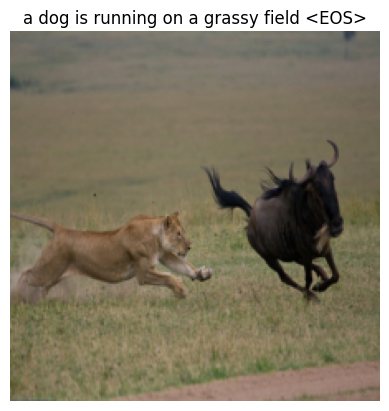

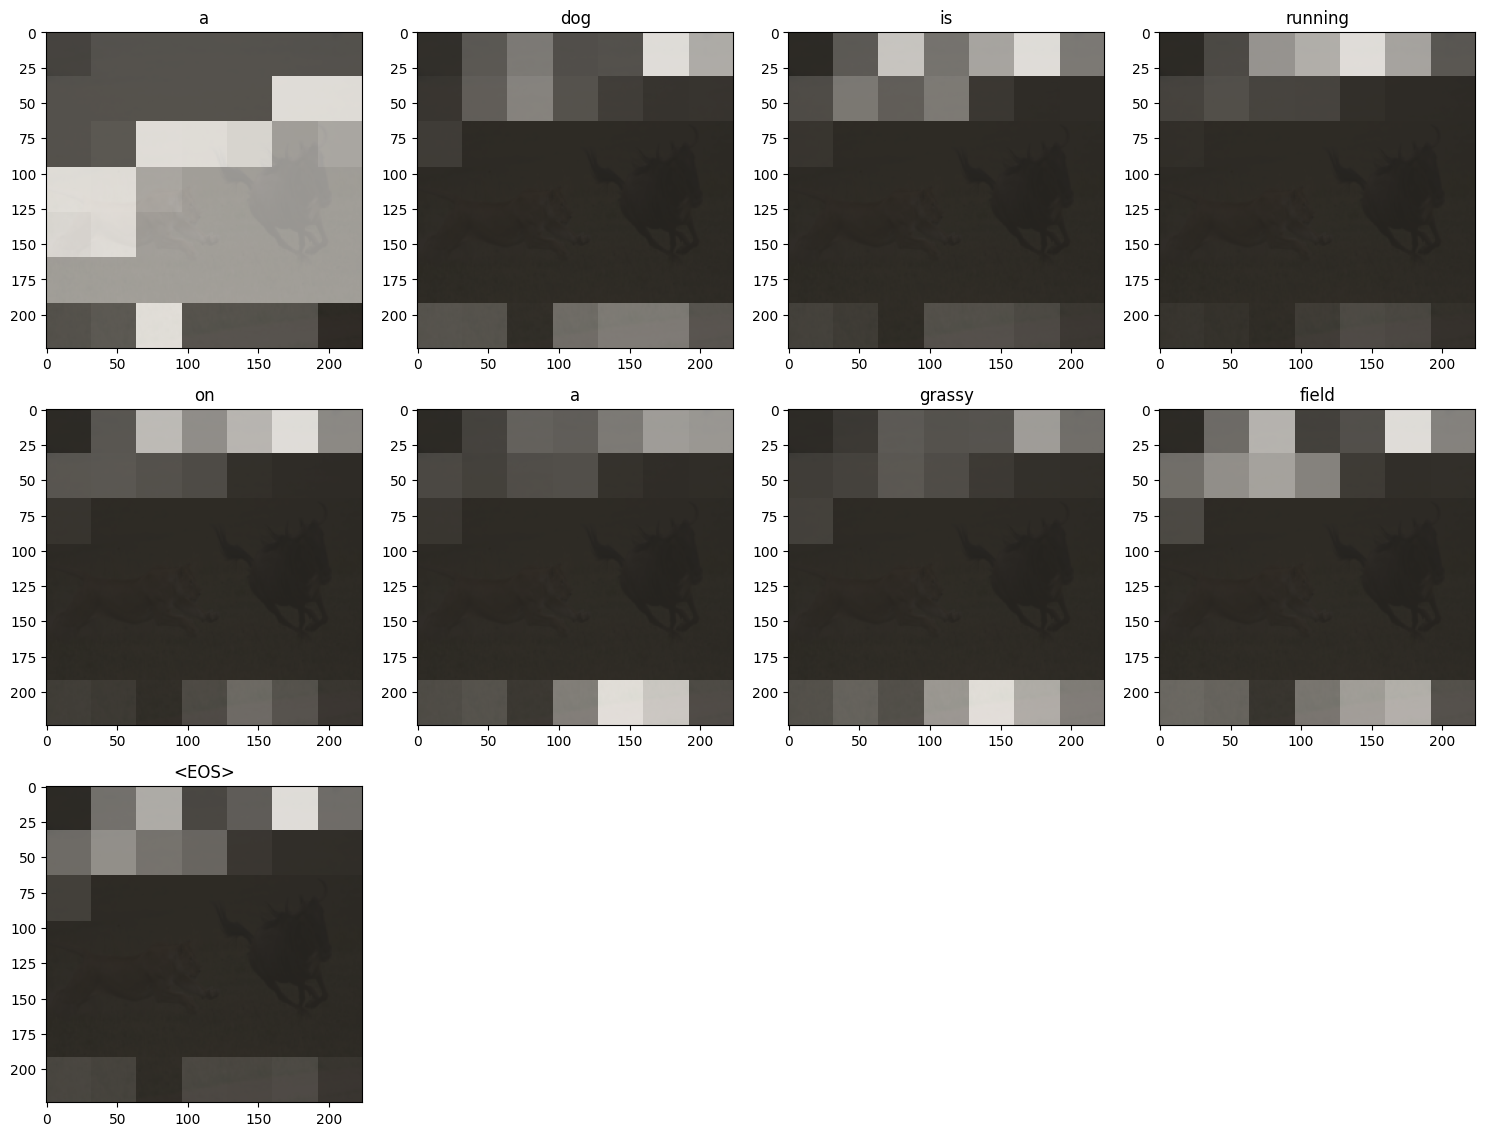

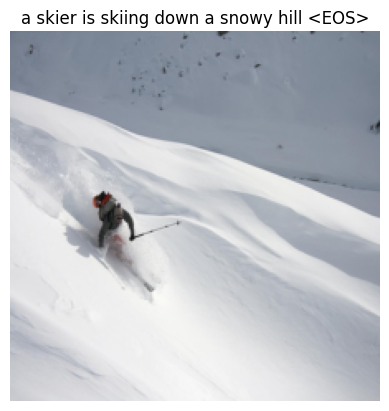

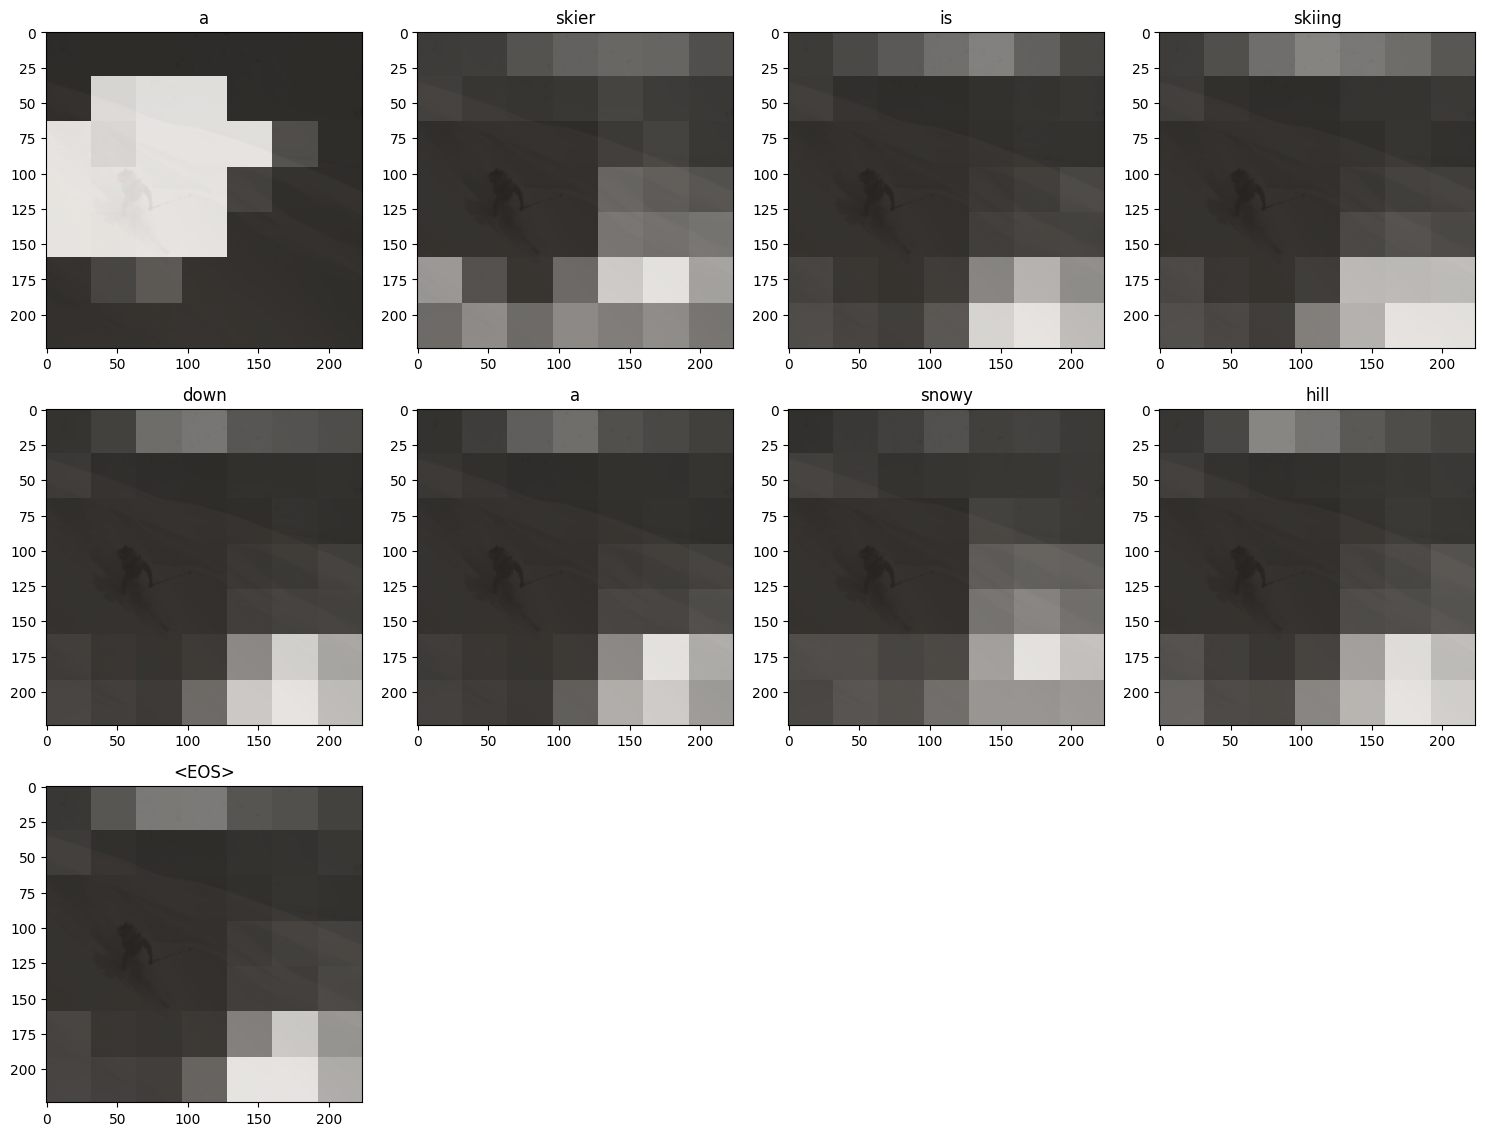

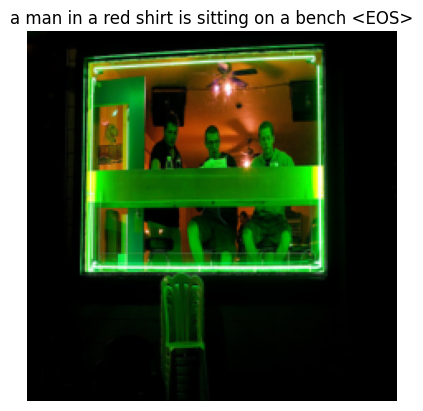

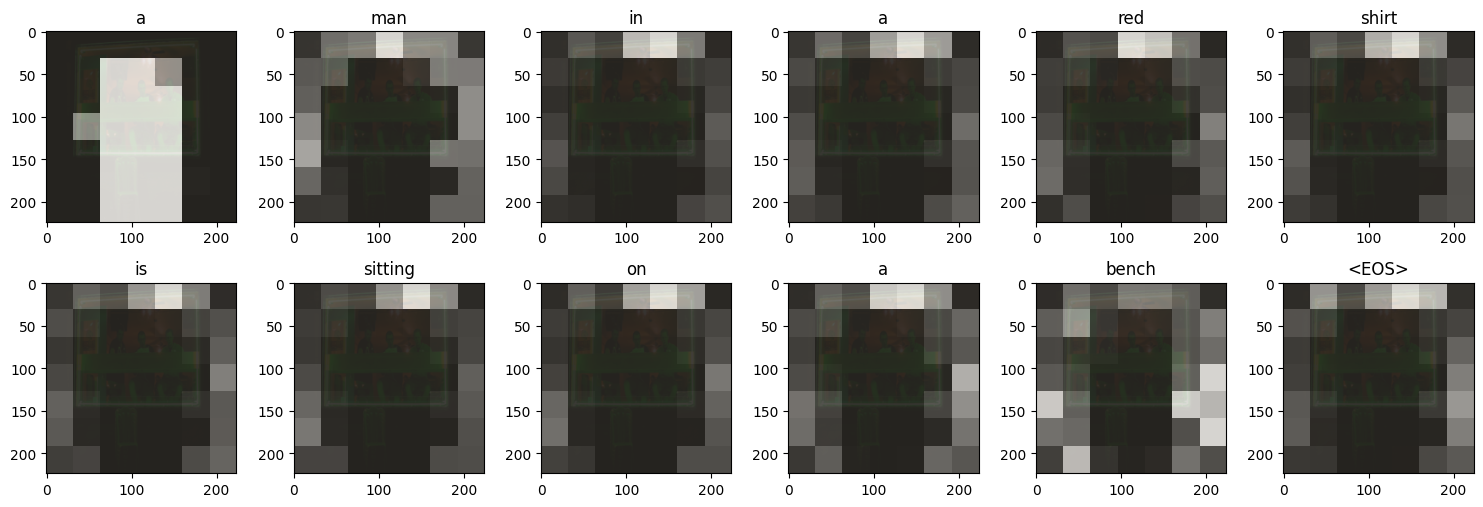

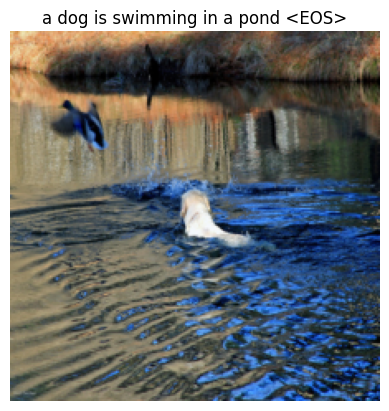

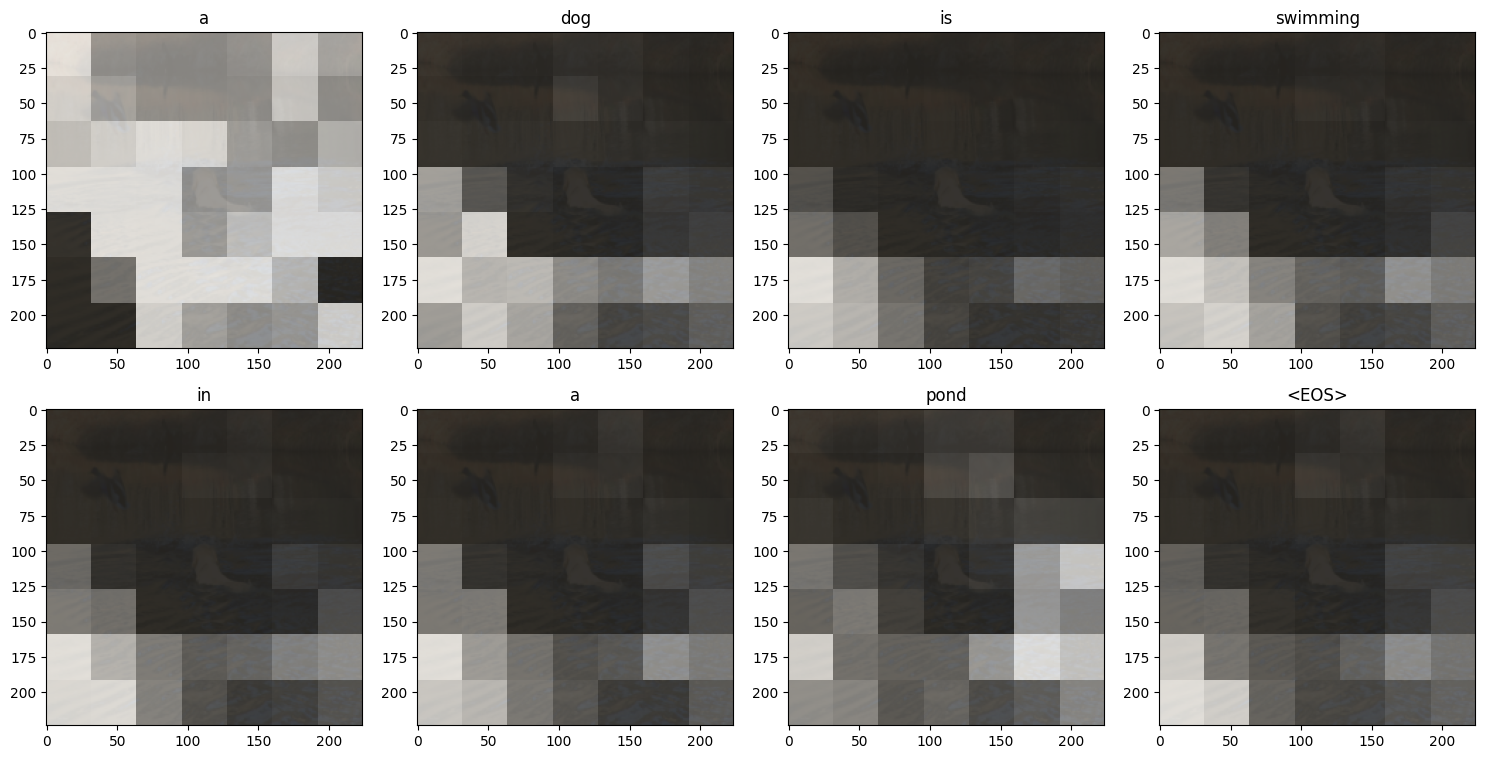

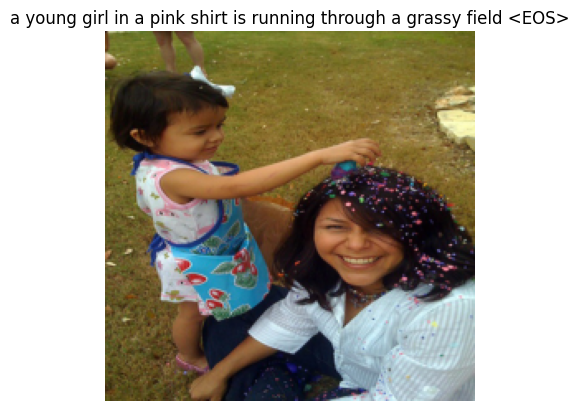

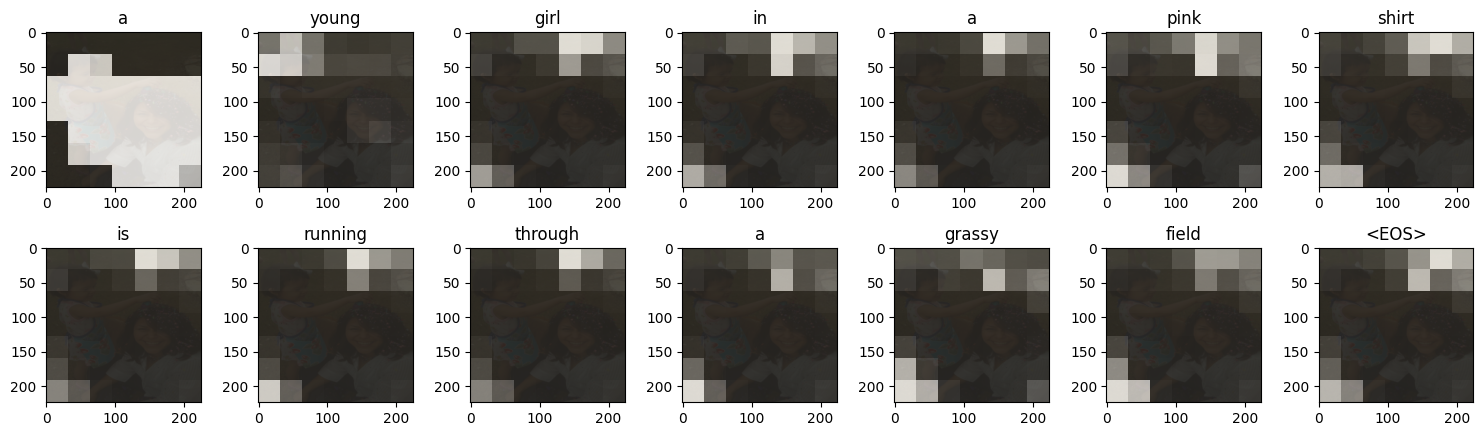

In [57]:
dataiter = iter(test_loader)

for _ in range(5):  
    images, _ = next(dataiter)
    
    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps, alphas = get_caps_from(img.unsqueeze(0))
    
    plot_attention(img1, caps, alphas)


In [60]:
def evaluate_metrics(model, test_loader, vocab, device):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for batch in test_loader:
            images, captions = batch
            images = images.to(device)

            features = model.encoder(images)
            for i in range(len(images)):
                caps, _ = model.decoder.generate_caption(features[i].unsqueeze(0), vocab=vocab)
                hypothesis = ' '.join(caps)
                reference = ' '.join([vocab.idx_to_word[idx] for idx in captions[i].tolist() if idx not in {0, 1, 2, 3}])

                hypotheses.append(hypothesis)
                references.append([reference])

    # Calculate BLEU scores
    smoothing_function = SmoothingFunction().method1
    bleu1_scores = [sentence_bleu(ref, hyp, weights=(1, 0, 0, 0), smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]
    bleu2_scores = [sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]
    bleu3_scores = [sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]
    bleu4_scores = [sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]
    avg_bleu1_score = np.mean(bleu1_scores)
    avg_bleu2_score = np.mean(bleu2_scores)
    avg_bleu3_score = np.mean(bleu3_scores)
    avg_bleu4_score = np.mean(bleu4_scores)

    # Prepare for CIDEr and METEOR
    gts = {i: refs for i, refs in enumerate(references)}
    res = {i: [hyp] for i, hyp in enumerate(hypotheses)}

    cider_scorer = Cider()
    _, cider_scores = cider_scorer.compute_score(gts, res)
    avg_cider_score = np.mean(cider_scores)

    meteor_scorer = Meteor()
    _, meteor_scores = meteor_scorer.compute_score(gts, res)
    avg_meteor_score = np.mean(meteor_scores)

    return avg_bleu1_score, avg_bleu2_score, avg_bleu3_score, avg_bleu4_score, avg_cider_score, avg_meteor_score

avg_bleu1, avg_bleu2, avg_bleu3, avg_bleu4, avg_cider, avg_meteor = evaluate_metrics(model, test_loader, dataset.vocab, device)
print(f"BLEU-1: {avg_bleu1}, BLEU-2: {avg_bleu2}, BLEU-3: {avg_bleu3}, BLEU-4: {avg_bleu4}, CIDEr: {avg_cider}, METEOR: {avg_meteor}")

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


BLEU-1: 0.5386546460947165, BLEU-2: 0.4092586447100116, BLEU-3: 0.3155679877178745, BLEU-4: 0.2487427363971746, CIDEr: 0.35092304814847464, METEOR: 0.11726897690423779


In [43]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-gc2xxx2x
  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-gc2xxx2x
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=109239 sha256=70db11b522912d55faa8ff86f128a64de60800d2d0c711ecde3db0e8efe513f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-c9h49b5_/wheels/8e/1a/5f/0c984ae3d65a4d7da4ba3407d2a8d8c8e85dd55f84d4936f04
Successfully built pycocotools


In [46]:
!pip install pycocoevalcap
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [70]:
test_dataset[1][1]

tensor([   1,   49,   44,   50,  445,   41,   25, 2100,   96,    2])

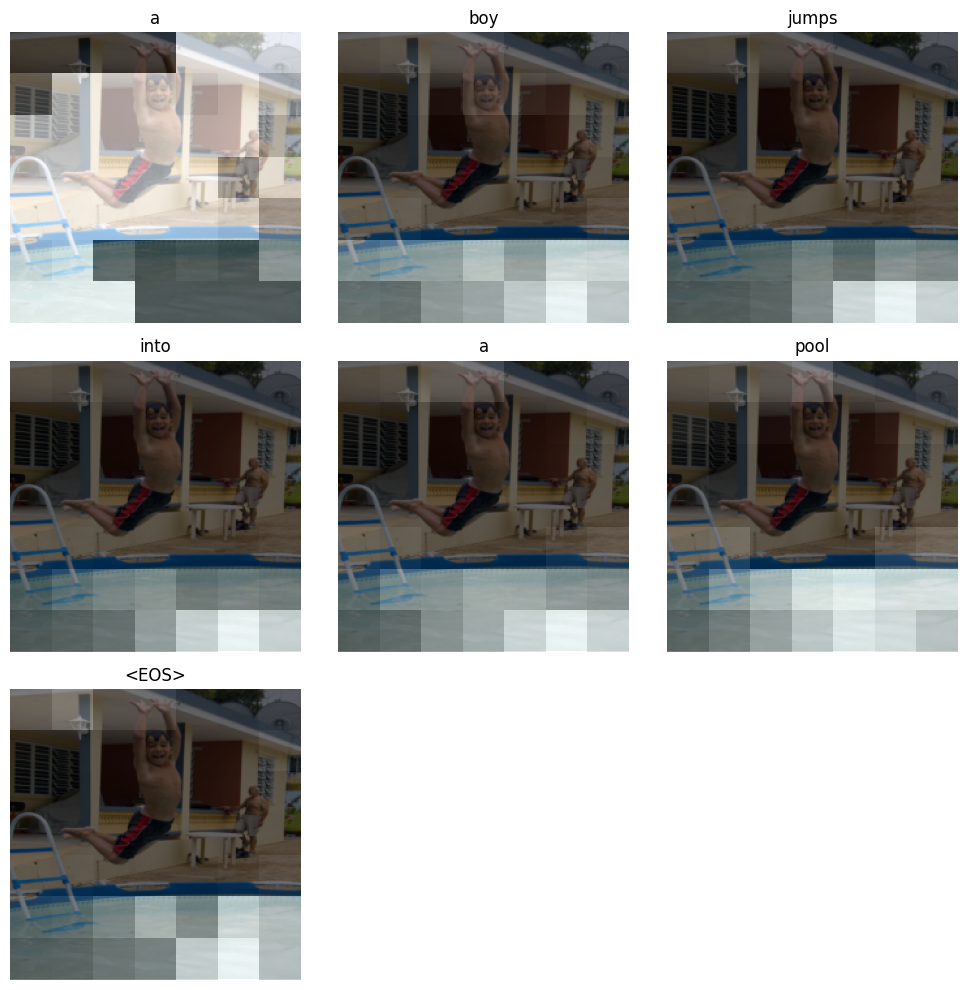

['a', 'boy', 'jumps', 'into', 'a', 'pool', '<EOS>']


In [75]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),          
    ])
    image = transform(image).unsqueeze(0)  
    return image


def predict_captions_and_attention(image_path, model, vocab, device):
    image = load_image(image_path).to(device)
    
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        captions, alphas = model.decoder.generate_caption(features, max_len=20, vocab=vocab)
    
    return captions, alphas


def plot_attention(image, captions, alphas):
    fig = plt.figure(figsize=(10, 10))
    
    for t in range(len(captions)):
        ax = fig.add_subplot(len(captions)//2, len(captions)//2, t+1)
        ax.imshow(image.squeeze(0).permute(1, 2, 0).numpy())  # Convert to numpy array
        attention_map = alphas[t].reshape(7, 7)  # No need for .cpu().numpy() on NumPy arrays
        ax.imshow(attention_map, cmap='gray', alpha=0.6, extent=(0, 224, 224, 0))
        ax.set_title(captions[t])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


image_path = '/kaggle/input/dddddd/indir (10).png'
captions, alphas = predict_captions_and_attention(image_path, model, dataset.vocab, device)
plot_attention(load_image(image_path), captions, alphas)
print(captions)